In [5]:
import pandas as pd
import torch
import re
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
from scipy.sparse.linalg import svds
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict
from scipy.sparse import lil_matrix

In [6]:
from model import EmbeddingTaskDataset, LSTMClassifier
import torch.nn.functional as F


In [7]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/ashnadua/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
train_data = 'dataset/train.csv'
test_data = 'dataset/test.csv'

df_train = pd.read_csv(train_data)
df_test = pd.read_csv(test_data)


In [9]:
# df_train["Class Index"]

In [10]:
# for i in df_train["Class Index"]:
#     if i==0:
#         print(i)

In [11]:
df_train.head()


,Class Index,Description
0,3,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Reuters - Private investment firm Carlyle Grou...
2,3,Reuters - Soaring crude prices plus worries\ab...
3,3,Reuters - Authorities have halted oil export\f...
4,3,"AFP - Tearaway world oil prices, toppling reco..."


In [12]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    return ['<START>'] + tokens + ['<END>']


In [13]:
def build_vocab(corpus):
    vocab = set()
    for doc in corpus:
        for word in doc:
            vocab.add(word)
    vocab_index = {word: i for i, word in enumerate(vocab)}
    return vocab_index


In [14]:
train_data_description = df_train["Description"].tolist()[:20000]
train_data_description = [preprocess_text(desc) for desc in train_data_description]

test_data_description = df_test["Description"].tolist()
test_data_description = [preprocess_text(desc) for desc in test_data_description]


In [15]:
vocab_index = build_vocab(train_data_description)

In [16]:
class SVD_Embeddings:
    def __init__(self, corpus, vocab_index, window_size=1):
        self.corpus = corpus
        self.vocab_index = vocab_index
        self.window_size = window_size

    def build_co_occurrence_matrix(self):
        self.vocab_size = len(self.vocab_index)
        co_occurrence_counts = defaultdict(float)

        for doc in self.corpus:
            doc_len = len(doc)
            for i, word in enumerate(doc):
                for j in range(i + 1, min(i + self.window_size + 1, doc_len)):
                    co_occurrence_counts[(vocab_index[word], vocab_index[doc[j]])] += 1

        self.co_occurrence_matrix = lil_matrix((self.vocab_size, self.vocab_size), dtype=np.float32)
        for (word_i, word_j), count in co_occurrence_counts.items():
            self.co_occurrence_matrix[word_i, word_j] = count

        return self.co_occurrence_matrix

    def svd_process(self, embedding_dims, saveFlag):
        self.u, self.s, self.vt = svds(self.co_occurrence_matrix, k=100)
        self.word_vectors = self.u

        norms = np.linalg.norm(self.word_vectors, axis=1, keepdims=True)
        norms[norms == 0] = 1e-8

        word_vectors_normalized = self.word_vectors / norms
        self.word_vectors_dict = {word: vector.tolist() for word, vector in zip(vocab_index, word_vectors_normalized)}

        if saveFlag == 1:
            self.save_embeddings()

        return self.word_vectors_dict

    def save_embeddings(self):
        torch.save(self.word_vectors_dict, 'svd_word_vectors.pt')
        
    def load_embeddings(self, embeddings_path):
        self.word_vectors_dict = torch.load(embeddings_path)


In [17]:
embedding_dim = 100
save_flag = 1
window = 5

In [18]:
svd = SVD_Embeddings(train_data_description, vocab_index, window)
co_matrix = svd.build_co_occurrence_matrix()
word_vectors_dict_svd = svd.svd_process(embedding_dim, save_flag)


In [24]:
svd.save_embeddings()

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [26]:
labels = df_train["Class Index"].tolist()[:20000]

labels_test = df_test["Class Index"].tolist()

word_vectors_svd = np.array(list(word_vectors_dict_svd.values()))
word_vectors_svd_tensor = torch.tensor(word_vectors_svd, dtype=torch.float32)


In [27]:
input_dim = len(vocab_index)
embedding_dim = len(word_vectors_svd[0])
hidden_dim = 128  # You may adjust this
output_dim = df_train["Class Index"].nunique()  # Number of unique classes
batch_size = 128
num_epochs = 10

In [28]:
train_dataset = EmbeddingTaskDataset(train_data_description, vocab_index, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)

test_dataset = EmbeddingTaskDataset(test_data_description, vocab_index, labels_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=test_dataset.collate_fn)


In [23]:
model = LSTMClassifier(input_dim, embedding_dim, hidden_dim, output_dim, word_vectors_svd_tensor)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)

In [29]:
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

Epoch 1, Loss: 1.257986165915325
Epoch 2, Loss: 0.8894381227007337
Epoch 3, Loss: 0.7800664218368044
Epoch 4, Loss: 0.7372141765181426
Epoch 5, Loss: 0.7118055619251956
Epoch 6, Loss: 0.6992989334331197
Epoch 7, Loss: 0.6889379149789263
Epoch 8, Loss: 0.6833525455681382
Epoch 9, Loss: 0.6778828645967374
Epoch 10, Loss: 0.6725791829406835


In [30]:
model.save_model("svd-classification-model.pt")

## Test Metrics

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [1]:
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        predicted = model.predict(texts)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1_micro = f1_score(all_labels, all_predictions, average='micro')
f1_macro = f1_score(all_labels, all_predictions, average='micro')

print(f'Accuracy on test data: {accuracy}')
print(f'Precision on test data: {precision}')
print(f'Recall on test data: {recall}')
print(f'F1 micro score on test data: {f1_micro}')
print(f'F1 macro score on test data: {f1_macro}')


Accuracy:  81.11842105263159
Precision:  81.23127252696534
Recall:  81.11842105263159
F1 Macro:  81.11842105263159
F1 Micro:  81.12894736842107


## Confusion Matrix - Test Set

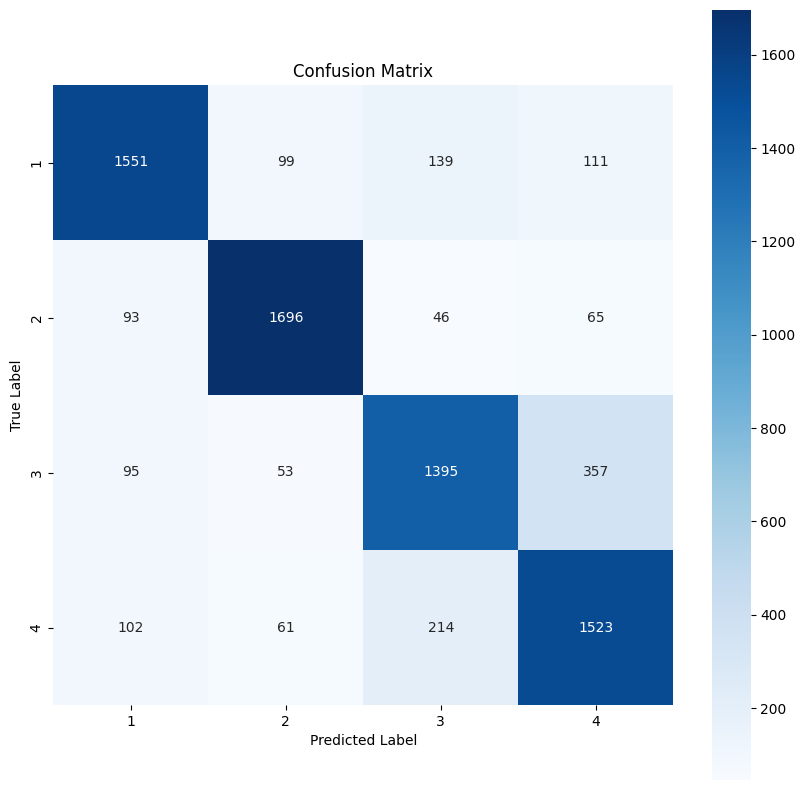

In [51]:
cm = confusion_matrix(all_labels, all_predictions)
class_names = [1, 2, 3, 4]

max_value = cm.max()

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, square=True, fmt='d', cmap='Blues', vmax=max_value, 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Train Metrics

In [52]:
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for texts, labels in train_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        predicted = model.predict(texts)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1_micro = f1_score(all_labels, all_predictions, average='micro')
f1_macro = f1_score(all_labels, all_predictions, average='macro')

print(f'Accuracy on test data: {accuracy * 100}')
print(f'Precision on test data: {precision * 100}')
print(f'Recall on test data: {recall * 100}')
print(f'F1 micro score on test data: {f1_micro * 100}')
print(f'F1 macro score on test data: {f1_macro * 100}')


Accuracy on test data: 82.48
Precision on test data: 82.39581821823145
Recall on test data: 82.38967696912428
F1 micro score on test data: 82.48
F1 macro score on test data: 82.48


## Confusion Matrix - Train Set

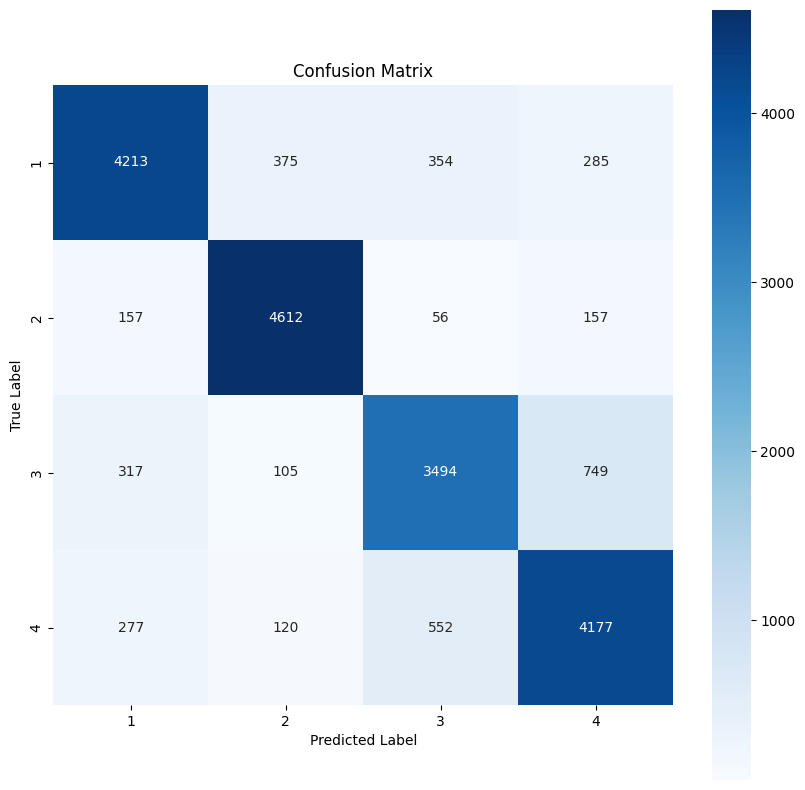

In [53]:
cm = confusion_matrix(all_labels, all_predictions)
class_names = [1, 2, 3, 4]

max_value = cm.max()

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, square=True, fmt='d', cmap='Blues', vmax=max_value, 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Hyper Parameter Tuning

In [54]:
window_sizes = [1, 2, 3, 4, 5]
model_performance = []

In [55]:
input_dim = len(vocab_index)
embedding_dim = 100
hidden_dim = 128
output_dim = df_train["Class Index"].nunique()
batch_size = 128
num_epochs = 10

In [56]:
for window_size in window_sizes:
    print("Window Size: ", window_size)
    print()
    svd = SVD_Embeddings(train_data_description, vocab_index, window_size)
    co_matrix = svd.build_co_occurrence_matrix()
    word_vectors_dict_svd = svd.svd_process(embedding_dim, save_flag)
    
    word_vectors_svd = np.array(list(word_vectors_dict_svd.values()))
    word_vectors_svd_tensor = torch.tensor(word_vectors_svd, dtype=torch.float32)

    model = LSTMClassifier(input_dim, embedding_dim, hidden_dim, output_dim, word_vectors_svd_tensor)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the device
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')
        
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            predicted = model.predict(texts)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1_macro = f1_score(all_labels, all_predictions, average='macro')
    f1_micro = f1_score(all_labels, all_predictions, average='micro')
    
    filename = f'./checkpoints/SVD_{window_size}.pth'
    
    model_performance.append({
        'filename': filename,
        'window_size': window_size,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    })
    
    model.save_model(filename)
    

Window Size:  1

Epoch 1, Loss: 1.317256934323888
Epoch 2, Loss: 1.0531821846961975
Epoch 3, Loss: 0.9339669453110665
Epoch 4, Loss: 0.879897520800305
Epoch 5, Loss: 0.8504556428854633
Epoch 6, Loss: 0.8316874511682304
Epoch 7, Loss: 0.8164105305246486
Epoch 8, Loss: 0.8053824267569621
Epoch 9, Loss: 0.7955959754385007
Epoch 10, Loss: 0.7893920612942641
Window Size:  2

Epoch 1, Loss: 1.2900388863435976
Epoch 2, Loss: 0.9892193420677428
Epoch 3, Loss: 0.8713950594519354
Epoch 4, Loss: 0.8198845337150963
Epoch 5, Loss: 0.7925052840238923
Epoch 6, Loss: 0.7746508899767688
Epoch 7, Loss: 0.7627825205493125
Epoch 8, Loss: 0.7519236624620522
Epoch 9, Loss: 0.7449349047272069
Epoch 10, Loss: 0.740305537630798
Window Size:  3

Epoch 1, Loss: 1.272754286504855
Epoch 2, Loss: 0.9395283851653907
Epoch 3, Loss: 0.822224113591917
Epoch 4, Loss: 0.7767193332599227
Epoch 5, Loss: 0.7529015487926022
Epoch 6, Loss: 0.7360238622707925
Epoch 7, Loss: 0.7258701855969277
Epoch 8, Loss: 0.718574347010084
E

In [58]:
for model in model_performance:
    print("Window Size", model['window_size'])
    print("Accuracy: ", model['accuracy'])
    print("Precision: ", model['precision'])
    print("Recall: ", model['recall'])
    print("F1 Macro: ", model['f1_macro'])
    print("F1 Micro: ", model['f1_micro'])
    print()

Window Size 1
Accuracy:  0.7247368421052631
Precision:  0.7318043558193509
Recall:  0.7247368421052631
F1 Macro:  0.7206423398741639
F1 Micro:  0.7247368421052631

Window Size 2
Accuracy:  0.7689473684210526
Precision:  0.7745677385956158
Recall:  0.7689473684210526
F1 Macro:  0.7680713922770068
F1 Micro:  0.7689473684210525

Window Size 3
Accuracy:  0.7836842105263158
Precision:  0.7894321699718885
Recall:  0.7836842105263158
F1 Macro:  0.7820802606085641
F1 Micro:  0.7836842105263156

Window Size 4
Accuracy:  0.8032894736842106
Precision:  0.8057104324719496
Recall:  0.8032894736842106
F1 Macro:  0.8037418040877977
F1 Micro:  0.8032894736842106

Window Size 5
Accuracy:  0.8132894736842106
Precision:  0.8159484750906595
Recall:  0.8132894736842106
F1 Macro:  0.8129673148225791
F1 Micro:  0.8132894736842107

